# Etape_2 : Préparez la veille technique en NLP ou en computer vision :

In [5]:
# preparing datasets

from pathlib import Path
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import DeiTFeatureExtractor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# preprocessing

from transformers import DeiTFeatureExtractor
from torchvision import transforms
from PIL import Image
import torch

import re
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.patches as patches
from collections import defaultdict

/home/garth/anaconda3/envs/ProtoViT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# verify CUDA and GPU

print("CUDA disponible :", torch.cuda.is_available())
print("Nombre de GPU :", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Nom du GPU :", torch.cuda.get_device_name(0))
else:
    print("Aucun GPU disponible")

CUDA disponible : True
Nombre de GPU : 1
Nom du GPU : NVIDIA GeForce RTX 3090


#### Requirements utilisés pour ce projet : 

* env dédié : `conda activate ProtoViT`
* GPU configuration : 1 x NVIDIA RTX 3090 (24GB) avec CUDA: 12.7

Catégories :  
Home Furnishing, Baby Care, Watches, Home Decor & Festive Needs, Kitchen & Dining, Beauty and Personal Care, Computers          

## 2.2 - Stratégie de modélisation :

1. Préparer le dataset : Charger et organiser les données.
2. Préprocessing : Redimensionner  les images et normaliser l'intensité des pixels.
3. Data Augmentation : Intégrer des transformations pour améliorer la généralisation.
4. Entrainement et fine-tuning du modèle
5. Évaluation

### 2.2.1 - Préparation des données :

Afin d'éviter toute fuite d'information entre les jeux d'entrainement, de test et de validation, les précautions sont :
* Séparation du dataset complet en **train** et **test** avec `train_test_split` de SciKit-Learn
* Séparation du dataset **train** en **train_split** et **validation** `train_test_split` de SciKit-Learn pour la validation

In [3]:
# images folder path

img_path = "../data/Flipkart/Images/"

In [4]:
# load dataframe with categories

dataset = pd.read_csv('../data/Flipkart/dataset_with_categories.csv')

In [5]:
# retrieve categories

columns = ['image', 'category']
df = dataset[columns]

In [6]:
# create a dataframe with complete image path and her category per row

df.loc[:, 'image'] = img_path + df['image']

/tmp/ipykernel_3858227/543640052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'image'] = img_path + df['image']


In [7]:
df.head()

image         category
0  ../data/Flipkart/Images/55b85ea15a1536d46b7190...  Home Furnishing
1  ../data/Flipkart/Images/7b72c92c2f6c40268628ec...        Baby Care
2  ../data/Flipkart/Images/64d5d4a258243731dc7bbb...        Baby Care
3  ../data/Flipkart/Images/d4684dcdc759dd9cdf4150...  Home Furnishing
4  ../data/Flipkart/Images/6325b6870c54cd47be6ebf...  Home Furnishing

In [8]:
# split dataset to train, test and val

train_df, test_df = train_test_split(
    df, test_size=0.2, 
    stratify=df['category'], 
    random_state=42
)

train_df, val_df = train_test_split(
    train_df, 
    test_size=0.25, 
    stratify=train_df['category'], 
    random_state=42
)

In [9]:
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 630, Val: 210, Test: 210


Déplacement des images afin de trier les images de façon approprié pour le modèle :

datasets/  
├── train/  
│   ├── category1/  
│   ├── category2/  
│   └── ...  
├── val/  
│   ├── category1/  
│   ├── category2/  
│   └── ...  
└── test/  
    ├── category1/  
    ├── category2/  
    └── ...  


In [10]:
# prepare folder structure

path_train = "../datasets/train/"
path_val = "../datasets/val/"
path_test = "../datasets/test/"

list_path = [path_train, path_val, path_test]
list_category = train_df['category'].unique().tolist()

In [11]:
# create all categories folders in each path folders

for path in list_path:
    for cat in list_category:
        path_cat = Path(path + cat)
        path_cat.mkdir(parents=True, exist_ok=True)

In [19]:
# classify images 

def move_file_from_df(df, root_folder):
    """
    Function to classify images in her own category folder
    """
    
    for _, row in df.iterrows():
        origin_path = row['image']  
        category = row['category']
        destination_path = os.path.join(root_folder, category)  
        
        try:
            shutil.move(origin_path, destination_path)
            print(f"Fichier déplacé : {origin_path} -> {destination_path}")
        except Exception as e:
            #pass
            print(f"Erreur lors du déplacement de {origin_path} : {e}")

In [18]:
# execute classification of train, test and val folder

move_file_from_df(train_df, path_train)
move_file_from_df(val_df, path_val)
move_file_from_df(test_df, path_test)

---
### 2.2.2 - Preprocessing :

Le preprocessing va se limiter à redimmensionner les images dans un format compatible avec ProtoViT : 224x224, ainsi que normaliser les pixels.

In [12]:
# datasets path

root_dir = "/data/Formation_OC/Projet_08/datasets/"

In [6]:
def preprocess_image(image_path, output_size=(224, 224)):
    """
    Resize and normalize image
    """
    
    try:
        # open image
        with Image.open(image_path) as img:
            # resize
            img = img.resize(output_size)
            
            # convert and normalize
            img_array = np.asarray(img) / 255.0 
            
            if len(img_array.shape) == 2 or img_array.shape[2] != 3:
                img = img.convert("RGB")
                img_array = np.asarray(img) / 255.0
            
            # convert in image
            img_normalized = Image.fromarray((img_array * 255).astype(np.uint8))
            
            # save image
            img_normalized.save(image_path)
            print(f"Image prétraitée : {image_path}")
    except Exception as e:
        print(f"Erreur lors du traitement de l'image {image_path} : {e}")

In [7]:
# apply preprocessing on all images

for subdir, _, files in os.walk(root_dir):
    for file in files:
        file_path = os.path.join(subdir, file)

        if file.lower().endswith(('.jpg', '.jpeg')):
            preprocess_image(file_path)

Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/7915f1c0703450d4b1446c06066d9a59.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/b7e42b52534c5e49eb03817d754c2153.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/3f97735a6c61a3587cefceaef36c280c.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/d395b2f3d13ff8897f403c6141e0e39a.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/cc24426f00c1cf9ae0bf76e8bd23c336.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/dd9a5979c32bbdd836984529af862303.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/362714cbba2f5ae412d2f26bae99a266.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/ace154420a51fad090b3543995630051.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/ff24511994f

---
### 2.2.3 - Data augmentation du dataset Train :

Modification des 'paths' du fichier `ProtoViT/img_aug.py`  
Ajout de nouvelles augmentations :
* rotate
* skew
* shear
* random_brithness
* random_distorsion
* random_contrast
* zoom_random  
Puis exécution :

In [20]:
# execute data augmentation script with applied changes 

!python ../ProtoViT/img_aug.py

Initialised with 90 image(s) found.
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444C97EDD30>: 100%ented/Home Furnishing.
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444CA66DCA0>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444C97E0250>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444CA6625B0>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444C97E0B50>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444CA64DAC0>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444C97E0AF0>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444CA6626A0>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444C97D8430>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444CA64DC40>: 100%
Initialised with 90 image(s) found.
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444C97F5D60>: 100%ented/Home Furni

---
### 2.2.4 - Entrainement du modèle : 

**A. Configuration :**  
Modification de la configuration du fichier `settings.py` :

```
data_path =  "/data/Formation_OC/Projet_08/datasets/"
train_dir = data_path + 'train_augmented/'
test_dir = data_path + 'val/'
train_push_dir = data_path + 'train/'
```

**B. Surveillance des processus du serveur :**
* GPU et mémoire : `gpustat --watch`
* CPU et RAM : `htop`

**C. Entrainement :**  
L'entrainement se fait en lançant le script `main.py`.  


In [6]:
# apply train script

!python ../ProtoViT/main.py

0
training set size: 44100
push set size: 630
test set size: 210
batch size: 128
cuda
start training
weight coefs are: {'crs_ent': 1, 'clst': -0.8, 'sep': 0.5, 'l1': 0.005, 'orth': 0.005, 'coh': 0.001}
epoch: 	0
	warm
	train
	time: 	202.96463227272034
	total loss: 	9.279051443865132
	cross ent: 	0.5368359191559775
	orthogonal loss	1465.5874296676282
	cluster: 	0.31133175719269485
	slot of prototype 0: 	tensor([1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
	Estimated avg number of subpatches: 	4.0
	Estimated avg slots logit: 	tensor([0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408,
        0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408,
        0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408,
        0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408,
        0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408,
        0.0408, 0.0408, 0.0408,

**D. Choix du modèle :**  

Je récupère le fichier log d'entrainement où on retrouve les données par "epoch" et ensuite par "iteration".  
Les données "iteration" correspondent à l'étape de finetuning, je récupère donc celles ci afin de choisir le modèle final.

In [12]:
# retrieve log file

log_file_path = "../data/model/cait_xxs24_224/exp5/train.log"
with open(log_file_path, 'r') as file:
    lines = file.readlines()

In [13]:
# initialize variables

iterations = []
cross_ent_values = []
orthogonal_loss_values = []
separation_values = []
avg_separation_values = []
coherence_loss_values = []
accuracy_values = []
l1_values = []
current_iteration = None

In [14]:
# process the log file line by line

for i, line in enumerate(lines):
    # detect "iteration" line
    if line.startswith("iteration"):
        # extract the current iteration number
        match = re.search(r'\d+', line)
        if match:
            current_iteration = int(match.group(0))

    # detect "test" section
    if line.strip() == "test" and current_iteration is not None:
        # search for the required metrics in the next lines
        cross_ent, orthogonal_loss, separation, avg_separation = None, None, None, None
        coherence_loss, accuracy, l1 = None, None, None
        for j in range(i + 1, len(lines)):
            if lines[j].strip().startswith("cross ent:"):
                cross_ent = float(re.search(r'([\d.]+)', lines[j]).group(1))
            if lines[j].strip().startswith("orthogonal loss"):
                orthogonal_loss = float(re.search(r'([\d.]+)', lines[j]).group(1))
            if lines[j].strip().startswith("separation:"):
                separation = float(re.search(r'([\d.]+)', lines[j]).group(1))
            if lines[j].strip().startswith("avg separation:"):
                avg_separation = float(re.search(r'([\d.]+)', lines[j]).group(1))
            if lines[j].strip().startswith("coherence loss:"):
                coherence_loss = float(re.search(r'([\d.]+)%', lines[j]).group(1))
            if lines[j].strip().startswith("accu:"):
                accuracy = float(re.search(r'([\d.]+)%', lines[j]).group(1))
            if lines[j].strip().startswith("l1:"):
                l1 = float(re.search(r'([\d.]+)', lines[j]).group(1))
            # break when all metrics are found
            if all(v is not None for v in [cross_ent, orthogonal_loss, separation, avg_separation, coherence_loss, accuracy, l1]):
                break

        # append results if all metrics are found
        if all(v is not None for v in [cross_ent, orthogonal_loss, separation, avg_separation, coherence_loss, accuracy, l1]):
            iterations.append(current_iteration)
            cross_ent_values.append(cross_ent)
            orthogonal_loss_values.append(orthogonal_loss)
            separation_values.append(separation)
            avg_separation_values.append(avg_separation)
            coherence_loss_values.append(coherence_loss)
            accuracy_values.append(accuracy)
            l1_values.append(l1)

In [15]:
# create dataframe

df_iterations = pd.DataFrame({
    'Iteration': iterations,
    'Cross Ent': cross_ent_values,
    'Orthogonal Loss': orthogonal_loss_values,
    'Separation': separation_values,
    'Avg Separation': avg_separation_values,
    'Coherence Loss (%)': coherence_loss_values,
    'Accuracy (%)': accuracy_values,
    'L1': l1_values
})

In [16]:
df_iterations

Iteration  Cross Ent  Orthogonal Loss  Separation  Avg Separation  \
0           0   6.794518      4037.604004     0.51842         0.01253   
1           1   5.892922      4037.604004     0.51842         0.01253   
2           2   5.017894      4037.604004     0.51842         0.01253   
3           3   4.956648      4037.604004     0.51842         0.01253   
4           4   4.910954      4037.604004     0.51842         0.01253   
5           5   4.877521      4037.604004     0.51842         0.01253   
6           6   4.838213      4037.604004     0.51842         0.01253   
7           7   4.800231      4037.604004     0.51842         0.01253   
8           8   4.757818      4037.604004     0.51842         0.01253   
9           9   4.728672      4037.604004     0.51842         0.01253   
10         10   4.705462      4037.604004     0.51842         0.01253   
11         11   4.653992      4037.604004     0.51842         0.01253   
12         12   4.609086      4037.604004     0.51842         0.01253   
13         13   4.562581      4037.604004     0.51842         0.01253   
14         14   4.522724      4037.604004     0.51842         0.01253   

    Coherence Loss (%)  Accuracy (%)   L1  
0            11.879737     84.761905  1.0  
1            11.879737     84.761905  1.0  
2            11.879737     84.761905  1.0  
3            11.879737     84.761905  1.0  
4            11.879737     84.761905  1.0  
5            11.879737     84.761905  1.0  
6            11.879737     84.761905  1.0  
7            11.879737     84.761905  1.0  
8            11.879737     84.761905  1.0  
9            11.879737     84.761905  1.0  
10           11.879737     84.761905  1.0  
11           11.879737     84.761905  1.0  
12           11.879737     84.761905  1.0  
13           11.879737     84.761905  1.0  
14           11.879737     84.761905  1.0

Sur les valeurs relevées ici, seule l'entropie croisée évolue, les autres étant stable.  
Je représente l'entropie sur un graphique :

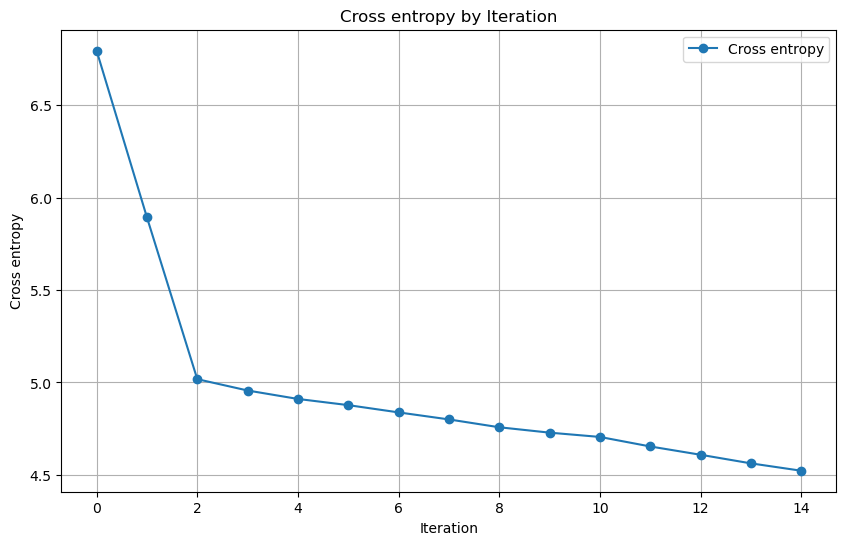

In [151]:
plt.figure(figsize=(10, 6))
plt.plot(df_iterations['Cross Ent'], label='Cross entropy', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cross entropy')
plt.title('Cross entropy by Iteration')
plt.legend()
plt.grid(True)
plt.show()

Dans l'absolue, la meilleure valeur de "Cross entropy" est la plus basse donc sur l'itération 14.  
Toutefois, afin d'éviter tout risque de surapprentissage je préfère choisir le compromis de l'itération 7, qui si situe au milieu mais avec un score d'entropie déjà proche du minimum.  

==> Modèle sélectionné : **7finetuned0.8476.pth**

log iteration: 	7  
* **train :**
train_time: 	98.53851437568665  
train_total loss: 	19.621873140335083  
train_cross ent: 	0.006171119689694925  
train_orthogonal loss	4037.60400390625  
train_cluster: 	0.9900387218871782  
train_separation:	0.4388152598295101  
train_avg separation:	0.0078631023941345  
train_coherence loss: 		11.87973690032959%  
train_accu: 		99.95684956395348%  
train_l1: 		93.99098205566406

* **test :**  
test_time: 	0.4934086799621582  
test_total loss: 	0.0  
test_cross ent: 	4.8002307415008545  
test_orthogonal loss	4037.60400390625  
test_cluster: 	0.9074898064136505  
test_separation:	0.5184200704097748  
test_avg separation:	0.012530156876891851  
test_coherence loss: 		11.87973690032959%  
test_accu: 		84.76190476190476%  
test_l1: 		93.99098205566406    

---
### 2.2.5 - Evaluation :

L'évaluation se pratique en réalisant la classification du jeu de `test` qui n'a jamais été vu par le modèle.  
Avec récupération des métrics :
* Accuracy
* F1-score
* Precision
* Recall
* Matrice de confusion

In [13]:
# prepare model loading

import sys
sys.path.append('../ProtoViT')
from analysis_settings import load_model_dir, load_model_name, img_name
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
load_model_dir = load_model_dir
load_model_name = load_model_name

load_model_path = os.path.join(load_model_dir, load_model_name)

In [14]:
# load model

print('Load model from ' + load_model_path)
ppnet = torch.load(load_model_path)
ppnet = ppnet.cuda()

Load model from /data/Formation_OC/Projet_08/data/model/cait_xxs24_224/exp5/7finetuned0.8476.pth


In [15]:
ppnet.eval()

PPNet(
	features: Cait(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-23): 24 x LayerScaleBlock(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): TalkingHeadAttn(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_l): Linear(in_features=4, out_features=4, bias=True)
        (proj_w): Linear(in_features=4, out_features=4, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): DropPath()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=768, out_fea

In [16]:
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [17]:
img_size = ppnet.img_size

In [18]:
# test images path

test_dir = '/data/Formation_OC/Projet_08/datasets/test'

In [19]:
# dataset preparation

test_datasets  = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
    ]))

In [20]:
# load dataset

test_loader = torch.utils.data.DataLoader(
    test_datasets, batch_size=64, shuffle=False
)

In [21]:
# predictions and metrics

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

all_labels = []
all_predictions = []

# evaluation loop
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        logits, _, _ = ppnet(images)  
        predictions = torch.argmax(logits, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=test_datasets.classes))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_predictions))

Accuracy: 0.8810
Classification Report:
                            precision    recall  f1-score   support

                 Baby Care       0.92      0.77      0.84        30
  Beauty and Personal Care       0.96      0.80      0.87        30
                 Computers       0.85      0.93      0.89        30
Home Decor & Festive Needs       0.76      0.87      0.81        30
           Home Furnishing       0.82      0.90      0.86        30
          Kitchen & Dining       0.93      0.93      0.93        30
                   Watches       0.97      0.97      0.97        30

                  accuracy                           0.88       210
                 macro avg       0.89      0.88      0.88       210
              weighted avg       0.89      0.88      0.88       210

Confusion Matrix:
[[23  1  1  1  4  0  0]
 [ 0 24  3  2  1  0  0]
 [ 0  0 28  1  0  0  1]
 [ 1  0  0 26  1  2  0]
 [ 1  0  0  2 27  0  0]
 [ 0  0  1  1  0 28  0]
 [ 0  0  0  1  0  0 29]]


In [22]:
cat_list = [
    "Baby Care",
    "Beauty and Personal Care",
    "Computers",
    "Home Decor & Festive Needs",
    "Home Furnishing",
    "Kitchen & Dining",
    "Watches"
]

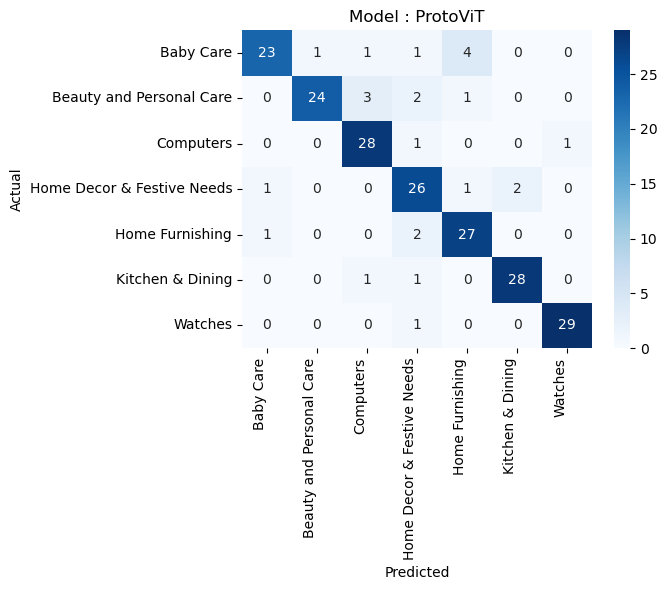

In [25]:
# confusion matrix

import seaborn as sns
cf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(7, 6))  
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=cat_list, yticklabels=cat_list)
plt.title("Model : ProtoViT")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90, ha="right")  
plt.yticks(rotation=0)  
plt.tight_layout()
plt.savefig('matrix.png')
plt.show()

---
---
## 2.3 - Analyses de Feature Importance :

Les analyses de Feature Importance globale et locale sont basées sur les prototypes afin d'interpréter les prédictions du modèle.  
Chaque prototype est associé à une classe spécifique et à des sous-patchs (taille 16x16).

---
### 2.3.1 - Feature Importance Globale :

In [11]:
# execute global analysis script

!python ../ProtoViT/global_analysis.py -gpuid 0

Load model from /data/Formation_OC/Projet_08/data/model/cait_xxs24_224/exp5/7finetuned0.8476.pth
start_epoch_number:  7
/home/garth/anaconda3/envs/ProtoViT/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
find nearest patches
batch 0
batch 1
batch 2
batch 3
batch 4
find nearest patches
batch 0
batch 1


*Fichier 'log' et images créées dans le dossier ./data/model/cait_xxs24_224/exp5/*

#### **Analyse du prototype 85 - TEST :**

Le script génère les images des 98 prototypes (14 par classe) en affichant les patchs où il a trouvé les caractéristiques intéressantes, ainsi que les 5 images qui qui s'en rapprochent le plus dans le dataset de Test.  
L'interprétation que le modèle effectue est : **ceci ressemble à cela**

In [18]:
#train_path = '../data/model/cait_xxs24_224/exp5/7finetuned0.8476_nearest_train/85/'
test_path = '../data/model/cait_xxs24_224/exp5/7finetuned0.8476_nearest_test/85/'

In [19]:
# search for prototype file and his nearest images

file_names = os.listdir(test_path)
prototype = next((file for file in file_names if "prototype" in file), None)
nearest_list = [file for file in file_names if "patch_with_box" in file]

In [20]:
# search for classes of analyzed prototype

class_ids_test = np.load(test_path + 'class_id.npy')
print("Contenu de full_class_id.npy du module TEST :")
print(class_ids_test)

Contenu de full_class_id.npy du module TEST :
[6 6 6 6 6]


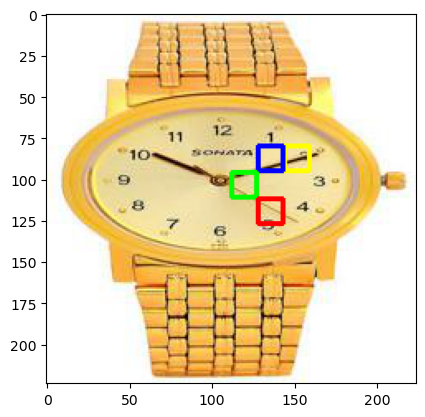

In [21]:
plt.imshow(imread(test_path + prototype))

**Commentaires :**  
Un prototype de la classe 6 (watches) avec les patchs des caractéristiques détectées par le modèle.

##### **Affichage des 5 images "NEAREST" - TEST :**

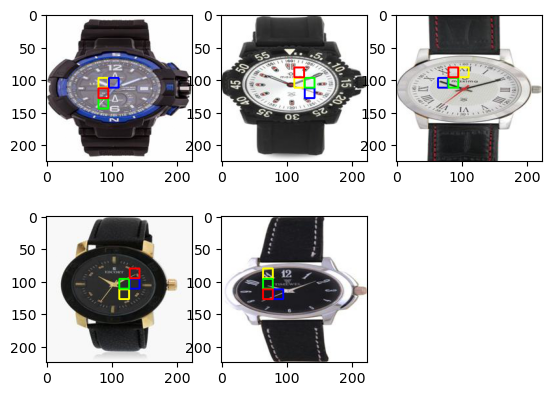

In [22]:
# display nearest images

idx_list = [p for p in nearest_list]

for idx, value in enumerate(idx_list):
    plt.subplot(2, 3, idx + 1)
    filename = test_path + nearest_list[idx]
    img = imread(filename)
    plt.imshow(img)
plt.show()

**Commentaires :**  
Dans le dataset de TEST, ce sont le 5 images qui ont les caractéristiques les plus proches du prototype 85.  

---
### 2.3.1 - Feature Importance locale :

Analyse de la Feature Importance locale avec en exemple l'image suivante :

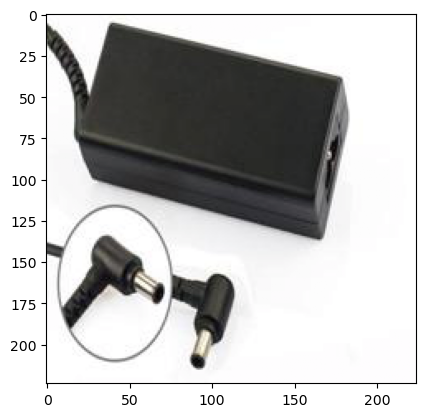

In [32]:
# example locale analysis

local_fi_path = '../data/model/analysis_results/data/'
analysed_img = imread(local_fi_path + 'original_img.png')
plt.imshow(analysed_img)

**Lancement du script d'analyse :**

In [53]:
# execute local analysis script

!python ../ProtoViT/local_analysis.py -gpuid 0

device=device(type='cuda')
load model from /data/Formation_OC/Projet_08/data/model/cait_xxs24_224/exp5/7finetuned0.8476.pth
model base architecture: cait
experiment run: Projet_08/data/model/cait_xxs24_224/exp5/
All prototypes connect most strongly to their respective classes.
/home/garth/anaconda3/envs/ProtoViT/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
test set size: 214
	test
	time: 	1.3076939582824707
	total loss: 	0.0
	cross ent: 	4.716812252998352
	orthogonal loss	4037.60400390625
	cluster: 	3.53079354763031
	slot of prototype 0: 	tensor([1., 1., 1., 1.], device='cuda

*Fichier 'log' et images créés dans le dossier ./data/model/analysis_results/*

**Analyse des résultats :**

Dans le dossier créé "most _activated_prototypes" on peut observer par patches, les prototypes qui ont été le plus activés, et qui vont influencer le plus la prédiction.

In [6]:
log_path = '../data/model/analysis_results/local_analysis.log'

In [7]:
# retrieve predicted classes

def top_classes_and_logits(log_path):
    with open(log_path, 'r') as file:
        lines = file.readlines()

    accuracy = None
    top_predictions = []
    
    for i, line in enumerate(lines):
        # retrieve model accuracy
        if "the accuracy of the model is:" in line:
            match = re.search(r"the accuracy of the model is:\s([\d.]+)", line)
            if match:
                accuracy = float(match.group(1))
                
        # find "top X predicted class"
        if line.startswith("top") and "predicted class" in line:
            match = re.search(r"top (\d+) predicted class: (\d+)", line)
            if match:
                top_rank = int(match.group(1))
                predicted_class = int(match.group(2))
                logit_line = lines[i + 1]  
                logit_match = re.search(r"logit of the class:\s([\d.]+)", logit_line)
                logit = float(logit_match.group(1)) if logit_match else None
                
                # retrieve prototype similarity scores
                prototypes = []
                for j in range(i + 2, len(lines), 4):
                    if not lines[j].startswith("prototype index"):
                        break
                    prototype_match = re.search(r"prototype index:\s(\d+)", lines[j])
                    similarity_match = re.search(r"activation value \(similarity score\):\s([\d.]+)", lines[j + 1])
                    weight_match = re.search(r"last layer connection with predicted class:\s([\d.]+)", lines[j + 3])
                    
                    if prototype_match and similarity_match and weight_match:
                        prototype_index = int(prototype_match.group(1))
                        similarity_score = float(similarity_match.group(1))
                        last_layer_weight = float(weight_match.group(1))
                        prototypes.append({
                            "prototype_index": prototype_index,
                            "similarity_score": round(similarity_score, 2),
                            "last_layer_weight": round(last_layer_weight, 3)
                        })

                top_predictions.append({
                    "rank": top_rank,
                    "predicted_class": predicted_class,
                    "logit": round(logit, 3),
                    "prototypes": prototypes
                })
    print(f"Accuracy: {accuracy}")
    for top in top_predictions:
        print(f"\nTop {top['rank']} predicted class: {top['predicted_class']} (logit: {top['logit']})")
        for proto in top['prototypes'][:5]:  # Limite à 5 prototypes
            print(f"  Prototype {proto['prototype_index']} - similarity score: {proto['similarity_score']} - "
                  f"last layer weight: {proto['last_layer_weight']}")
    
    return accuracy, top_predictions

In [8]:
accuracy, top_predictions = top_classes_and_logits(log_path)

Accuracy: 0.8504672897196262

Top 1 predicted class: 3 (logit: 46.378)
  Prototype 35 - similarity score: 3.96 - last layer weight: 0.868
  Prototype 38 - similarity score: 3.94 - last layer weight: 0.868
  Prototype 36 - similarity score: 3.94 - last layer weight: 0.867
  Prototype 31 - similarity score: 3.93 - last layer weight: 0.868
  Prototype 37 - similarity score: 3.92 - last layer weight: 0.872

Top 2 predicted class: 6 (logit: 2.608)
  Prototype 70 - similarity score: 0.65 - last layer weight: 0.947
  Prototype 71 - similarity score: 0.45 - last layer weight: 0.944
  Prototype 80 - similarity score: 0.44 - last layer weight: 0.945
  Prototype 72 - similarity score: 0.44 - last layer weight: 0.943
  Prototype 73 - similarity score: 0.43 - last layer weight: 0.94

Top 3 predicted class: 4 (logit: 2.335)
  Prototype 50 - similarity score: 1.29 - last layer weight: 0.885
  Prototype 51 - similarity score: 0.63 - last layer weight: 0.887
  Prototype 47 - similarity score: 0.52 - la

**Commentaires :**  
Avec le fichier log, on constate que la prédiction de la classe 3 a un logit largement supérieur aux autres.

In [32]:
# display most activated patches 

def plot_patches_and_prototypes(local_proto_path):
    file_names = os.listdir(local_proto_path)
    file_names = sorted(file_names)

    # fig
    fig, axes = plt.subplots(5, 2, figsize=(6, 8))  
    axes = axes.ravel()

    for i in range(1, 6):  
        # find file name
        original_img_file = next((f for f in file_names if f"most_highly_activated_patch_in_original_img_by_top-{i}_class" in f), None)
        activated_img_file = next((f for f in file_names if f"top-{i}_activated" in f), None)

        # original img
        if original_img_file:
            original_img = imread(os.path.join(local_proto_path, original_img_file))
            axes[(i - 1) * 2].imshow(original_img)
            axes[(i - 1) * 2].set_title(f"Top-{i} Original patches")
            axes[(i - 1) * 2].axis("off")
        else:
            axes[(i - 1) * 2].axis("off")

        # prototype
        if activated_img_file:
            activated_img = imread(os.path.join(local_proto_path, activated_img_file))
            axes[(i - 1) * 2 + 1].imshow(activated_img)
            axes[(i - 1) * 2 + 1].set_title(f"Top-{i} Activated prototype")
            axes[(i - 1) * 2 + 1].axis("off")
        else:
            axes[(i - 1) * 2 + 1].axis("off")
    plt.tight_layout()
    plt.savefig('FI_locale.png')
    plt.show()

##### **TOP 1 - prédictions :**

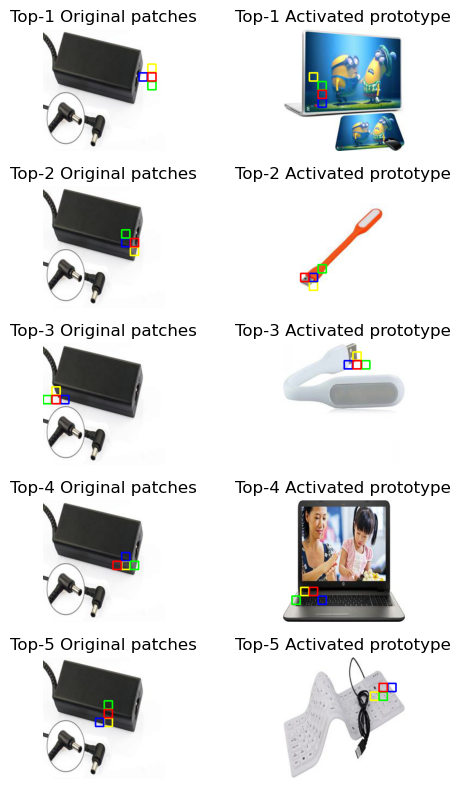

In [37]:
local_proto_path = '../data/model/analysis_results/data/top-1_class_prototypes_class3/'
plot_patches_and_prototypes(local_proto_path)

Récupération des logs :  
Top 1 predicted class: 3 (logit: 46.378)  
  * Prototype 35 - similarity score: 3.96 - last layer weight: 0.868  
  * Prototype 38 - similarity score: 3.94 - last layer weight: 0.868  
  * Prototype 36 - similarity score: 3.94 - last layer weight: 0.867  
  * Prototype 31 - similarity score: 3.93 - last layer weight: 0.868  
  * Prototype 37 - similarity score: 3.92 - last layer weight: 0.872  

Avec le principe du "ceci ressembe à cela" :  
On peut voir ici les caractéristiques le plus importantes (top5). On retrouve sur l'image de gauche les patchs de l'image testée et à droite le protoype qui ressemble le plus.  
On peut voir ici que les 5 prototypes les plus importants font partis de la classe ***computers***, ce qui est bien la classe de notre image testée.

##### **TOP 2 - prédictions :**

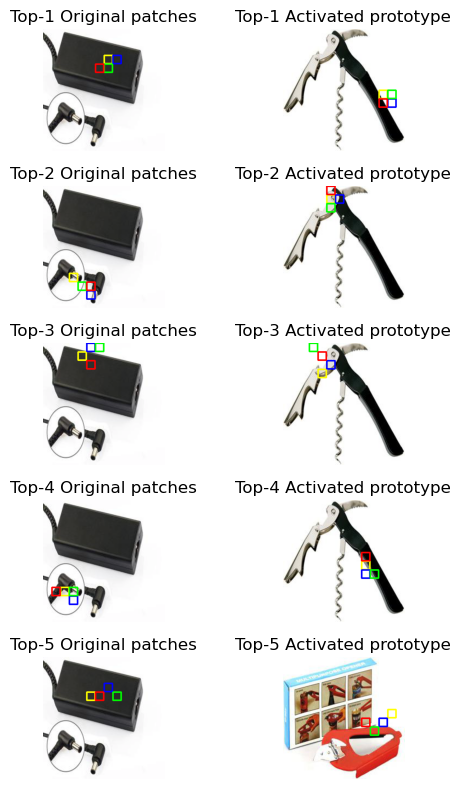

In [36]:
local_proto_path_top2 = '../data/model/analysis_results/data/top-2_class_prototypes_class6/'
plot_patches_and_prototypes(local_proto_path_top2)

Récupération des logs :  
Top 2 predicted class: 6 (logit: 2.608)  
  * Prototype 70 - similarity score: 0.65 - last layer weight: 0.947
  * Prototype 71 - similarity score: 0.45 - last layer weight: 0.944
  * Prototype 80 - similarity score: 0.44 - last layer weight: 0.945
  * Prototype 72 - similarity score: 0.44 - last layer weight: 0.943
  * Prototype 73 - similarity score: 0.43 - last layer weight: 0.94

Toujours avec la méthode de "ceci ressemble à ceci", la 2ème classe avec le score les plus haut en prédiction est la classe 6, avec un logit de 2.6, qui est largemetn inférieur au 46.3 du Top1.